#### Example: Downloading and writing to disk a raster map



In [1]:
import os
import pandas as pd, geopandas as gp, numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import shape
from rasterio.windows import from_bounds
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
try: os.chdir('/home/jovyan/work/')
except: pass

### What is this code doing?

In this code, we will download elevation data for the Metropolitan Statistical Area of Indianapolis. For this purpose, I have made life easier in two ways. 

First, I have already downloaded the geodataframe with the shapes of tiles for the 1 arc-degree digital elevation model of the USGS (Sourced `https://cugir-data.s3.amazonaws.com/00/90/96/cugir-009096-index.geojson`). 

Second, I have also sourced a geodataframe with the boundaries of the Metropolitan Statistical Areas according to 1999 definitions, which was constructed by Gilles Duranton and Diego Puga for "Urban Growth and its Aggregate Implications" and is available as part of the replication package here: `https://diegopuga.org/data/urbangrowth/`

With these two pieces of information, we are going to do the following: We are going to spatially join the tiles of the elevation model data with the MSA shape of the city of Indianapolis to get the tiles that cover the metropolitan area of Indianapolis. Then, we are going to create a raster dataset with the extent of these tiles. For each of the data URLs associated to these tiles, we are going to download the elevation raster and write it to the corresponding coordinates in our target dataset. In this way, we save to our computer a contiguous elevation dataset which covers our required extent. 

In [3]:
##Read in the files
quads_localfile = ('./data/elevation_quads.geojson')
msa_localfile = ('./data/msa1999_boundaries.shp')
elevation_quads = gp.read_file(quads_localfile)
msa_1999 = gp.read_file(msa_localfile).to_crs(elevation_quads.crs)

In [4]:
##Get the bounds of the conterminous USA from the MSA shapefile
bounds = msa_1999.to_crs(elevation_quads.crs).dissolve().bounds.values[0]

In [5]:
elevation_quads = elevation_quads.cx[bounds[0]:bounds[2],bounds[3]:bounds[1]] #Trim elevation quads to the extent of the conterminous USA
non_empty_bool = []
for i in range(len(elevation_quads.index)):
    url = elevation_quads.iloc[i].downloadUrl #Check URL for raster data exists
    non_empty_bool.append(len(url) > 0) #Append to bool list
elevation_quads = elevation_quads[non_empty_bool] #Keep only tiles with raster data

In [6]:
##Get the geodataframe row for Indianapolis:
indy_shape = msa_1999[['Indianapolis' in name for name in msa_1999.NAME]]

#### Plot the elevation tiles and the shape of the Indianapolis MSA together:

This little code plots the two geodataframes together, we can notice that the MSA of Indianapolis overlaps with four tiles of the elevation dataset.

<Axes: >

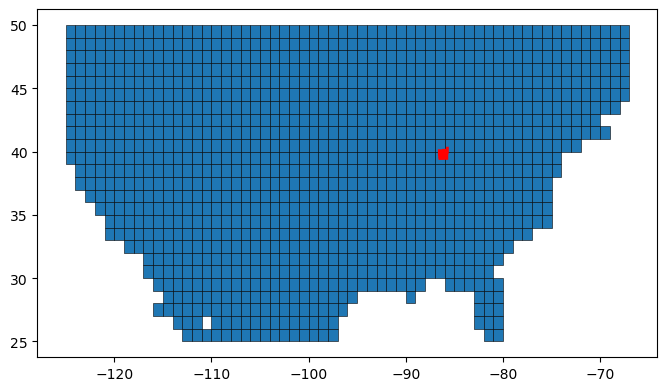

In [7]:
f, ax = plt.subplots(1, figsize = (8, 5))

elevation_quads.plot(ax = ax, edgecolor = 'black', linewidth = 0.4)
indy_shape.plot(ax = ax, color = 'red')


#### Get a sample array to see what it looks like:

Take a random row, open the data, and see its shape: it is 3612*3612. (Actually, the documentation of this dataset states that each tile overlaps with the next one by six pixels, so that later in the download we will be trimming the outermost six pixels of each tile so that they can be joined seamlessly)

In [8]:
with rasterio.open(elevation_quads.iloc[3].downloadUrl) as sample_raster:# open with rasterio the cloud-stored data using the download url
    sample_array = sample_raster.read()[0,:,:]
    print(sample_array.shape)

(3612, 3612)


#### Do a spatial join to keep the tiles that overlap with Indianapolis

In [9]:
elevation_quads = elevation_quads.sjoin(msa_1999[['Indianapolis' in name for name in msa_1999.NAME]])
elevation_quads

,title,label,available,downloadUrl,websiteUrl,size,geometry,index_right,FIPS,Cnt_FIPS,NAME,AREA_HA,XCOORD,YCOORD
86,USGS 1 Arc Second n40w086 20210617,n40w086,true,https://prd-tnm.s3.amazonaws.com/StagedProduct...,https://www.sciencebase.gov/catalog/item/60d2c...,50 MB,"POLYGON ((-86.00000 39.00000, -85.00000 39.000...",114,3480,1,"Indianapolis, IN",917267,-86.117349,39.807328
87,USGS 1 Arc Second n40w087 20210617,n40w087,true,https://prd-tnm.s3.amazonaws.com/StagedProduct...,https://www.sciencebase.gov/catalog/item/60d2c...,53 MB,"POLYGON ((-87.00000 39.00000, -86.00000 39.000...",114,3480,1,"Indianapolis, IN",917267,-86.117349,39.807328
104,USGS 1 Arc Second n41w086 20210617,n41w086,true,https://prd-tnm.s3.amazonaws.com/StagedProduct...,https://www.sciencebase.gov/catalog/item/60d2c...,49 MB,"POLYGON ((-86.00000 40.00000, -85.00000 40.000...",114,3480,1,"Indianapolis, IN",917267,-86.117349,39.807328
105,USGS 1 Arc Second n41w087 20210617,n41w087,true,https://prd-tnm.s3.amazonaws.com/StagedProduct...,https://www.sciencebase.gov/catalog/item/60d2c...,50 MB,"POLYGON ((-87.00000 40.00000, -86.00000 40.000...",114,3480,1,"Indianapolis, IN",917267,-86.117349,39.807328


#### What are the bounds of these four tiles?

In [10]:
elevation_bounds = elevation_quads.total_bounds
elevation_bounds

array([-87.,  39., -85.,  41.])

#### Create the "transform" object for the new dataset

Create the transform object of the new dataset given its bounds and the fact that it will be a square of size 7200*7200 (Using a method in Rasterio)

In [11]:
transform_copy = rasterio.transform.from_bounds(
    elevation_bounds[0], 
    elevation_bounds[1], 
    elevation_bounds[2], 
    elevation_bounds[3], 
    3600*2, 
    3600*2
    )

Set the location of the dataset to store the elevation of indianapolis:

In [12]:
download_path = './data/indianapolis_elevation.tif'

#### Do the big download:

First, create the empty rasterio dataset to write to, based on the bounds, transform, etc. that we have determined. 

Then, for each tile in the four tiles that overlap indianapolis, write the data from that tile to the area covered by its bounds, in the dataset that we just created.

In [13]:
big_elevation_raster = rasterio.open(download_path, 
        'w', 
        driver = "GTiff", 
        dtype = sample_array.dtype, 
        height = 3600*2,
        width = 3600*2,
        nodata = 0, 
        count = 1,
        crs = elevation_quads.crs,
        transform = transform_copy,
        compress = 'DEFLATE',
        tiled=True, 
        blockxsize=256, 
        blockysize=256, 
        BIGTIFF='YES')
big_elevation_raster.close() ##Create the raster and close it
with rasterio.open(download_path, 'r+') as big_elevation_raster:
    print("Downloading elevation model to big geotiff")
    counter = tqdm(total=len(elevation_quads.index), desc = "Progress")
    for i in range(len(elevation_quads.index)):
        url = elevation_quads.iloc[i].downloadUrl  #Get URL of geotiff
        with rasterio.open(url) as rasterio_to_write: #Open geotiff
            bounds_to_write = elevation_quads.iloc[i].geometry.bounds
            #get bounds of geotiff to write
            rows, cols = rasterio.transform.rowcol(transform_copy, (bounds_to_write[0], bounds_to_write[2]), (bounds_to_write[3], bounds_to_write[1])) 
            #Get the columns and rows in big_elevation_raster from its transform and the bounds of the elevation geotiff
            data_to_write = rasterio_to_write.read(window = Window.from_slices(slice(6, 3606), slice(6, 3606))) #read the data itself
            writewindow = Window.from_slices(rows, cols)
            big_elevation_raster.write(data_to_write, window = writewindow)
        counter.update()
    counter.refresh()
    factors = [8,16,64]
    big_elevation_raster.build_overviews(factors, Resampling.nearest)
    big_elevation_raster.update_tags(ns='rio_overview', resampling='nearest')

Progress: 100%|██████████| 4/4 [00:39<00:00,  9.62s/it]

## And that's all!